# Passenger Satisfaction

[Kaggle Dataset](https://www.kaggle.com/teejmahal20/airline-passenger-satisfaction)

The dataset is for Airline Satisfaction 


In [1]:
import os
import numpy as np
import pandas as pd
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing \
    import OneHotEncoder, LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [3]:
pd.options.display.max_columns = None

## Problem Definition

### DataSet 

For this dataset, the default properties are (specified by the owner of dataset) as such:

- Gender: Gender of the passengers (Female, Male)
- Customer Type: The customer type (Loyal customer, disloyal customer)
- Age: The actual age of the passengers
- Type of Travel: Purpose of the flight of the passengers (Personal Travel, Business Travel)
- Class: Travel class in the plane of the passengers (Business, Eco, Eco Plus)
- Flight distance: The flight distance of this journey
- Inflight wifi service: Satisfaction level of the inflight wifi service (0:Not Applicable; 1-5)
- Departure/Arrival time convenient: Satisfaction level of Departure/Arrival time convenient
- Ease of Online booking: Satisfaction level of online booking
- Gate location: Satisfaction level of Gate location
- Food and drink: Satisfaction level of Food and drink
- Online boarding: Satisfaction level of online boarding
- Seat comfort: Satisfaction level of Seat comfort
- Inflight entertainment: Satisfaction level of inflight entertainment
- On-board service: Satisfaction level of On-board service
- Leg room service: Satisfaction level of Leg room service
- Baggage handling: Satisfaction level of baggage handling
- Check-in service: Satisfaction level of Check-in service
- Inflight service: Satisfaction level of inflight service
- Cleanliness: Satisfaction level of Cleanliness
- Departure Delay in Minutes: Minutes delayed when departure
- Arrival Delay in Minutes: Minutes delayed when Arrival
- Satisfaction: Airline satisfaction level(Satisfaction, neutral or dissatisfaction) 
## 

## Preprocessing

#### Preliminary Exploration of Data

In [4]:
"""
The data is already split into training and test sets, but since I am not sure
how the data is split, I decide to remerge train.csv and test.csv and 
preprocess them together, and then make a training and test split.
"""
# Read the csv files
dummy_training = pd.read_csv(
    os.path.join("archive","train.csv")
)
dummy_test = pd.read_csv(
    os.path.join("archive","test.csv")
)
dataset = pd.concat([dummy_training, dummy_test], axis=0)
# del dummy_training, dummy_test

dataset = dataset.iloc[:, 1:]
dataset_cols = dataset.columns

# Assign input "features" and output labels
X = dataset.iloc[:,:-1].to_numpy()  # .values
Y = dataset.iloc[:,-1].to_numpy()  # .values

# print(dataset.shape)
# dataset.head(1)


In [5]:
"""
Generate Dictionaries to 
map column names to column numbers and vice-versa
"""

variables_num2name = {
    ind: name for ind, name in enumerate(dataset_cols)
}
variables_name2num = {
    name: ind for ind, name in enumerate(dataset_cols)
}

In [6]:
"""
Display the first row of data
"""
dataset.head(1)

# for col_name, val in dataset.iloc[0,:].iteritems():
#     print(f"{col_name}: {val}")

,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,1,5,3,5,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied


### Feature Engineering Discussion
Within preprocessing step, feature engineering may be necessary to correctly represent the features contained within the dataset. 

This is particularly relevant in our case. Since the dataset contains many categorical variables, that may be encoded in ways that significantly increase the number of fetures, and it is computationally costly to use all the dummy and original features. Therefore, dimensionality reduction by some means is prevalent.

In [7]:
"""
Inspecting the unique values for each default feature
"""

unique_values = []

for ind, col_name in enumerate(dataset_cols):
    # Gets unique values in each column
    dummy_vals = sorted(list(dataset[col_name].unique()))
    # Assign them into a row to be put into a separate dataframe
    unique_values.append(
        [
            ind, 
            dummy_vals, 
            dataset[col_name].isnull().sum(),  # = ...[...].isna().sum()
            min(dummy_vals), 
            max(dummy_vals),
        ]
    )
del dummy_vals

dataset_repr = pd.DataFrame(
    data=unique_values, 
    index=dataset_cols,
    columns= [
        "Variable No.", 
        "Unique Values", 
        "Number of Empty Entries",
        "Min.", 
        "Max.", 
    ]
)

dataset_repr

,Variable No.,Unique Values,Number of Empty Entries,Min.,Max.
id,0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",0,1,129880
Gender,1,"[Female, Male]",0,Female,Male
Customer Type,2,"[Loyal Customer, disloyal Customer]",0,Loyal Customer,disloyal Customer
Age,3,"[7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, ...",0,7,85
Type of Travel,4,"[Business travel, Personal Travel]",0,Business travel,Personal Travel
Class,5,"[Business, Eco, Eco Plus]",0,Business,Eco Plus
Flight Distance,6,"[31, 56, 67, 73, 74, 76, 77, 78, 80, 82, 83, 8...",0,31,4983
Inflight wifi service,7,"[0, 1, 2, 3, 4, 5]",0,0,5
Departure/Arrival time convenient,8,"[0, 1, 2, 3, 4, 5]",0,0,5
Ease of Online booking,9,"[0, 1, 2, 3, 4, 5]",0,0,5


#### Discussion of Features

It is apparent that the dataset contains both categorical variables  and numerical variables.

It should also be noted that the dataset contains:

> (Feature 7 - 20)

Rankings on likert-scale as some features, specifically the measurements of customer satisfaction is quantified as rankings of ordinal values (0,1,2,3,4,5) that may either be:
  - one-hot encoded
    - With 14 Features that will be encoded with one-hot vectors of 5 (or 6) dimensions, the feature size will grow very large compared to original dataset.
  - dummy encoded 
  - Helmert encoded
  - used as is (discrete variables / already ordinal encoded)
  
It may be logical to test different encodings for these features in this case.

> (Feature 3)

A specific population-related feature (Age), may be irrelevant in the sense that it is within a natural range, hence binning the ages may make sense.

> (Features 1, 2, 4, 5)

- Some other features are of direct categorical nature. One-hot encoding again may make sense

> (Features 6, 21, 22)

- Some features are of continuously varying nature



In [8]:
nominal_vars = [1, 2, 4, 5]
numerical_vars = [3, 6, 21, 22]
ordinal_vars = [i for i in range(7, 21)]

In [9]:
# Update the :dataset_repr: representation for dataset, will be used later

ls = nominal_vars + numerical_vars + ordinal_vars
cache = []

for count, var in enumerate((dataset_cols)):
    if count in numerical_vars:
        dummy = "numerical"
    elif count in nominal_vars:
        dummy = "nominal"
    elif count in ordinal_vars:
        dummy = "ordinal"
    else:
        dummy = None
    cache.append(dummy)

dataset_repr["var_type"] = cache
del cache

#### Train, Dev, Test Split

In order to prevent development on the whole dataset and cause information leakage, the data will be shuffled and resplitted, and all exploration will be done on the resplitted training data.

The dataset contains about 130'000 entries. In order to increase modelling accuracy down the line, most of the data will be used for training.

In [10]:
"""
Splitting the data into:
- Training Set, 
- Development Set, 
- Test Set
"""
#Split the dataset into 2 splits
X_, X_test, Y_, Y_test = train_test_split(
    X, Y, 
    test_size=0.08,  # 8% of all data is assigned to test set
    random_state=2300  
)

# Re-split the previously splitted dataset
    # 9& of all data previously not assigned to test set,
    # is assigned as dev set
X_train, X_dev, Y_train, Y_dev = train_test_split(
    X_, Y_,  
    test_size=0.09, 
    random_state=2300  # :REVIEW: Seed?
)

del X_, Y_

Y_train = Y_train.reshape((-1,1))
Y_dev = Y_dev.reshape((-1,1))
Y_test = Y_test.reshape((-1,1))

# print(X.shape, Y.shape ,X_train.shape, Y_train.shape)
training_data = pd.DataFrame(
    data=np.concatenate((X_train, Y_train), axis=1),
    columns=dataset_cols,
)
training_data = training_data.astype(dataset.dtypes.to_dict())

dev_data = pd.DataFrame(
    data=np.concatenate((X_dev, Y_dev), axis=1),
    columns=dataset_cols
)
dev_data = dev_data.astype(dataset.dtypes.to_dict())

test_data = pd.DataFrame(
    data=np.concatenate((X_test, Y_test), axis=1),
    columns=dataset_cols
)
test_data = test_data.astype(dataset.dtypes.to_dict())

In [11]:
"""
Encoding the output variable for Data Exploration
"""
# Non-optimal to assign a copy of "dataset":class:"DataFrame", 
#   but done for convenience.
df_train = training_data.copy()

# Encode the output variable
output_le = LabelEncoder()
output_le.fit(training_data["satisfaction"])

df_train["satisfaction"] = output_le.transform(df_train["satisfaction"])

#### Data Exploration

Explore the training data alias: df_train

##### Univariate Analysis

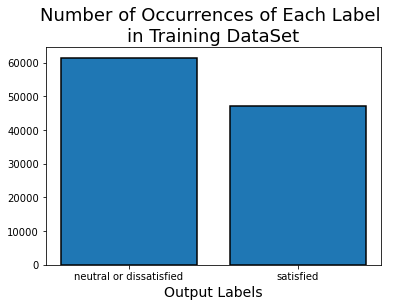

In [12]:
"""
Inspecting the distribution of output variable "Satisfaction"
"""
data = df_train["satisfaction"]
d = np.diff(np.unique(data)).min()
left_of_first_bin = data.min() - float(d)/2
right_of_last_bin = data.max() + float(d)/2


fig = plt.figure(figsize=(6, 4))
ax = plt.axes()
ax.set_xticks([i for i in range(2)])
ax.set_xticklabels([output_le.inverse_transform([i])[0] for i in range(2)])
ax.hist(data, np.arange(left_of_first_bin, right_of_last_bin + d, d),
        edgecolor='black', linewidth=1.5, rwidth=0.8)
ax.set_title("Number of Occurrences of Each Label \nin Training DataSet", fontsize=18)
ax.set_xlabel("Output Labels", fontsize = 14)
fig.add_axes(ax)
plt.show()

It appears to be that there is a slight imbalance between two output classes,
however, due to my limited understanding of handling these issues, for now, I am overlooking this issue. :REVIEW:

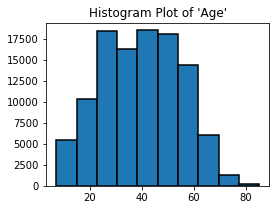

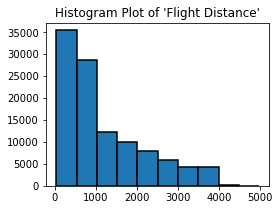

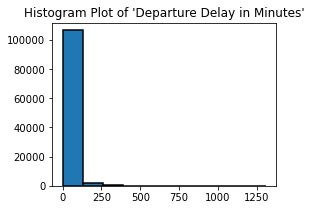

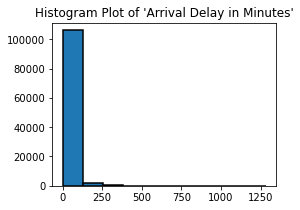

In [13]:
"""
Inspect the histogram of Numerical Variables
"""

for ind, feature_num in enumerate(numerical_vars):
    fig = plt.figure(ind, figsize=(4, 3))
    ax = plt.axes()
    ax.hist(
        df_train[variables_num2name[feature_num]], 
        edgecolor='black', linewidth=1.5, stacked=True)
    ax.set_title(
        f"Histogram Plot of \'{variables_num2name[feature_num]}\'"
    )

plt.draw()
plt.show(block=False)

The histogram of "Arrival Delay in Minutes" and "Departure Delay in Minutes" variables looks rather concerning with such skew and kurtosis. These features, if found to be highly correlated with output (in bivariate analysis), has to be inspected further.

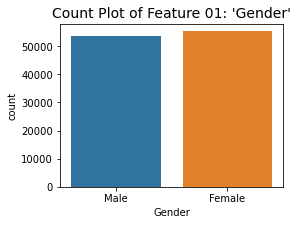

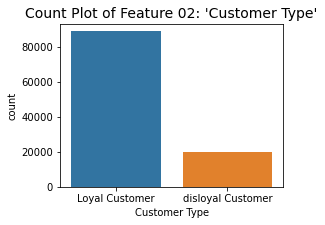

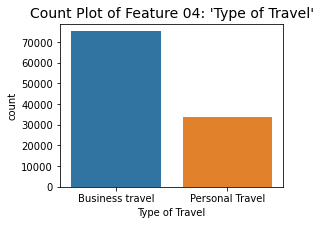

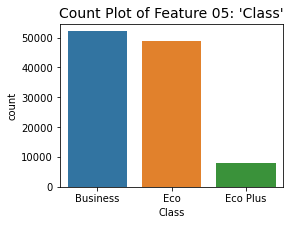

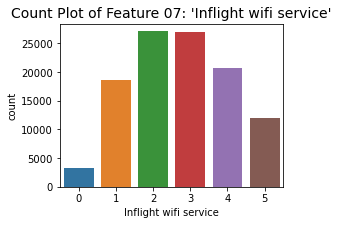

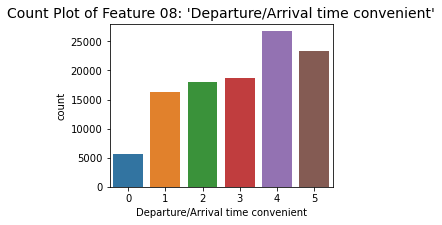

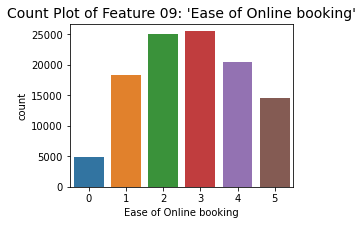

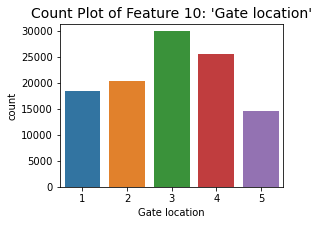

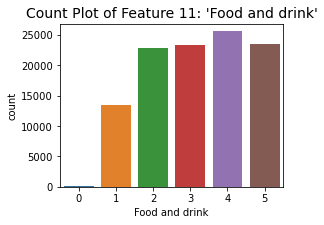

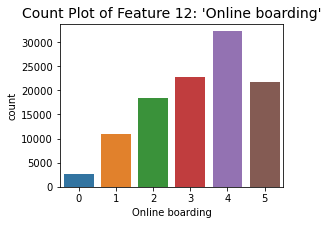

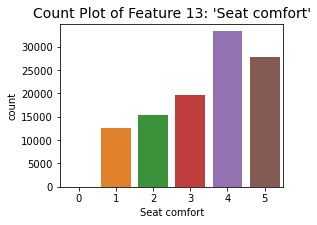

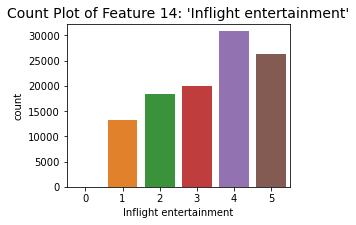

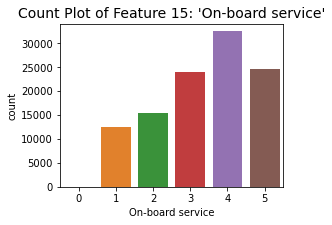

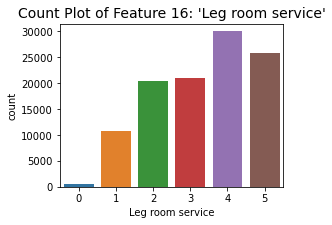

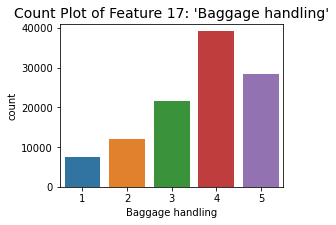

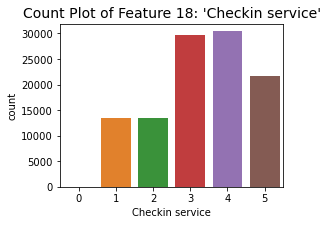

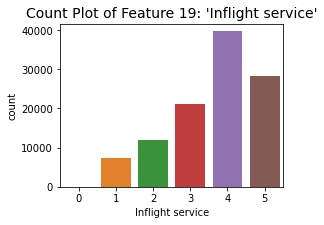

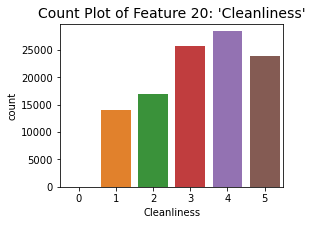

In [14]:
"""
Inspect the histogram of Nominal and Ordinal Variables
"""
# sns.set()
data = df_train

for ind, feature_num in enumerate(nominal_vars + ordinal_vars):
    fig = plt.figure(ind, figsize=(4, 3))
    ax = sns.countplot(
        data=data,
        x=variables_num2name[feature_num],
    )
    ax.set_title(
        f"Count Plot of Feature"
        f" {feature_num:02d}: \'{variables_num2name[feature_num]}\'",
        fontsize=14
        )
    fig.add_axes(ax)
    # ax.hist(, edgecolor='black', linewidth=1.5, density=True)

plt.draw()
plt.show(block=False)

"Customer Type", "Class" and "Type of Travel" features particularly have an imbalanced distribution of underlying categories. These features, if found to be highly correlated with output (in bivariate analysis), has to be inspected further.

##### Bivariate Analysis

As an assessment for correlations across different variables, an analysis will be conducted. However, since the data contains both ordinal, nominal, discrete numeric and continuous numeric variables, a generalizable method is desired.

Assuming the dataset does not have many outliers, the candidate methods to quantify correlation between variables are as such:
- Pearson Correlation Coefficient: Not suitable due to nominal variables
- Spearman Correlation Coefficient: Apparently is not robust for outliers
- Kendall's Tau
- Chi-Squared and Contingency Analysis
- Mutual Information
- Cramer's V
- Rank-biserial
- Logistic Regression
- Anova
- Uncertainity Coefficient = Theil's U

:REVIEW:

Nominal, ordinal, and numerical variables of the dataset will be compared within each group, e.g. correlations of numerical variables will be analysed separately from correlations of ordinal variables.

In order to analyse correlations across variable types, the features belonging to each variable type that have the significantly high correlation to the output will be chosen.


In [15]:
"""
Inspecting if there are any highly-correlated variables,
    including the output labels, across the same type of variables
"""
from correllationcalc import CorrelationCalculator

cc_numerical = CorrelationCalculator(
    df_train,
    numerical_vars,
    "numerical",
    include_output=True
)
cc_numerical.calculate()

cc_ordinal = CorrelationCalculator(
    df_train,
    ordinal_vars,
    "ordinal",
    include_output=True
)
cc_ordinal.calculate()

cc_nominal = CorrelationCalculator(
    df_train,
    nominal_vars,
    "nominal",
    include_output=True
)
cc_nominal.calculate()

pass

C:\Users\brknk\anaconda3\lib\site-packages\scipy\stats\stats.py:4812: RuntimeWarning: overflow encountered in longlong_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


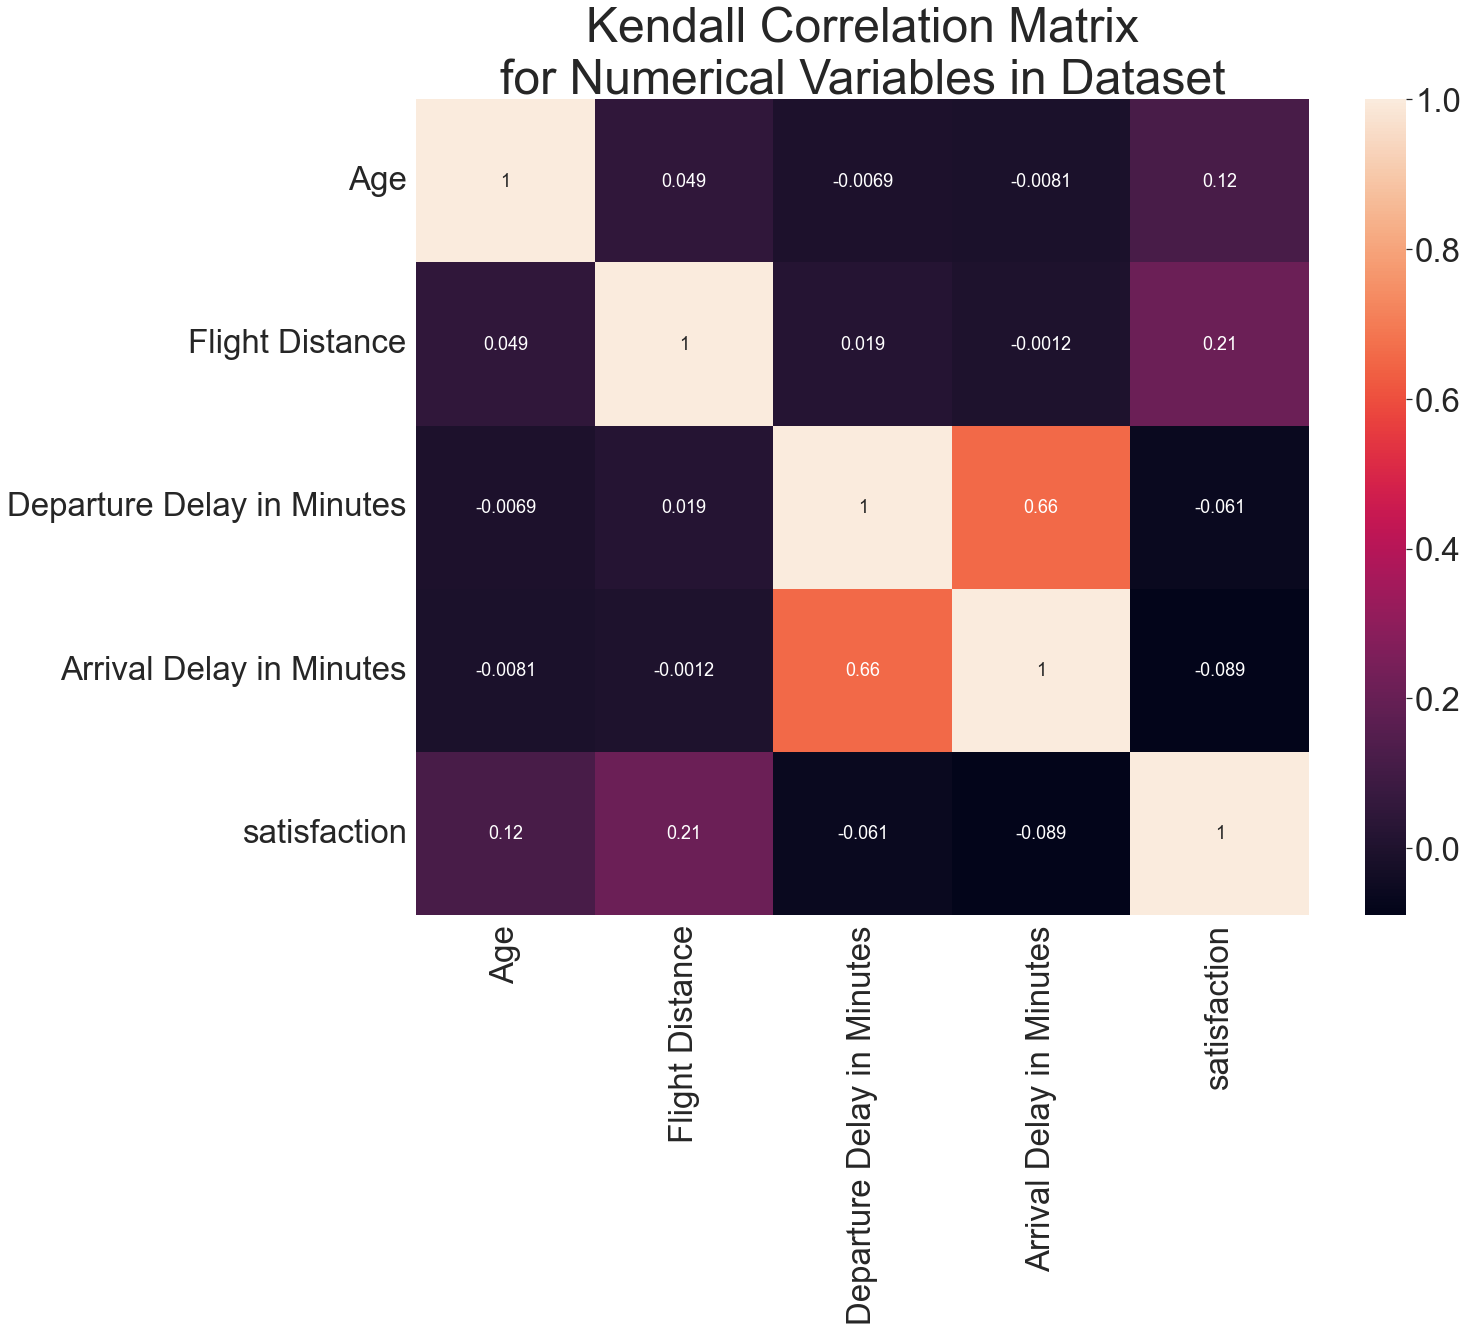

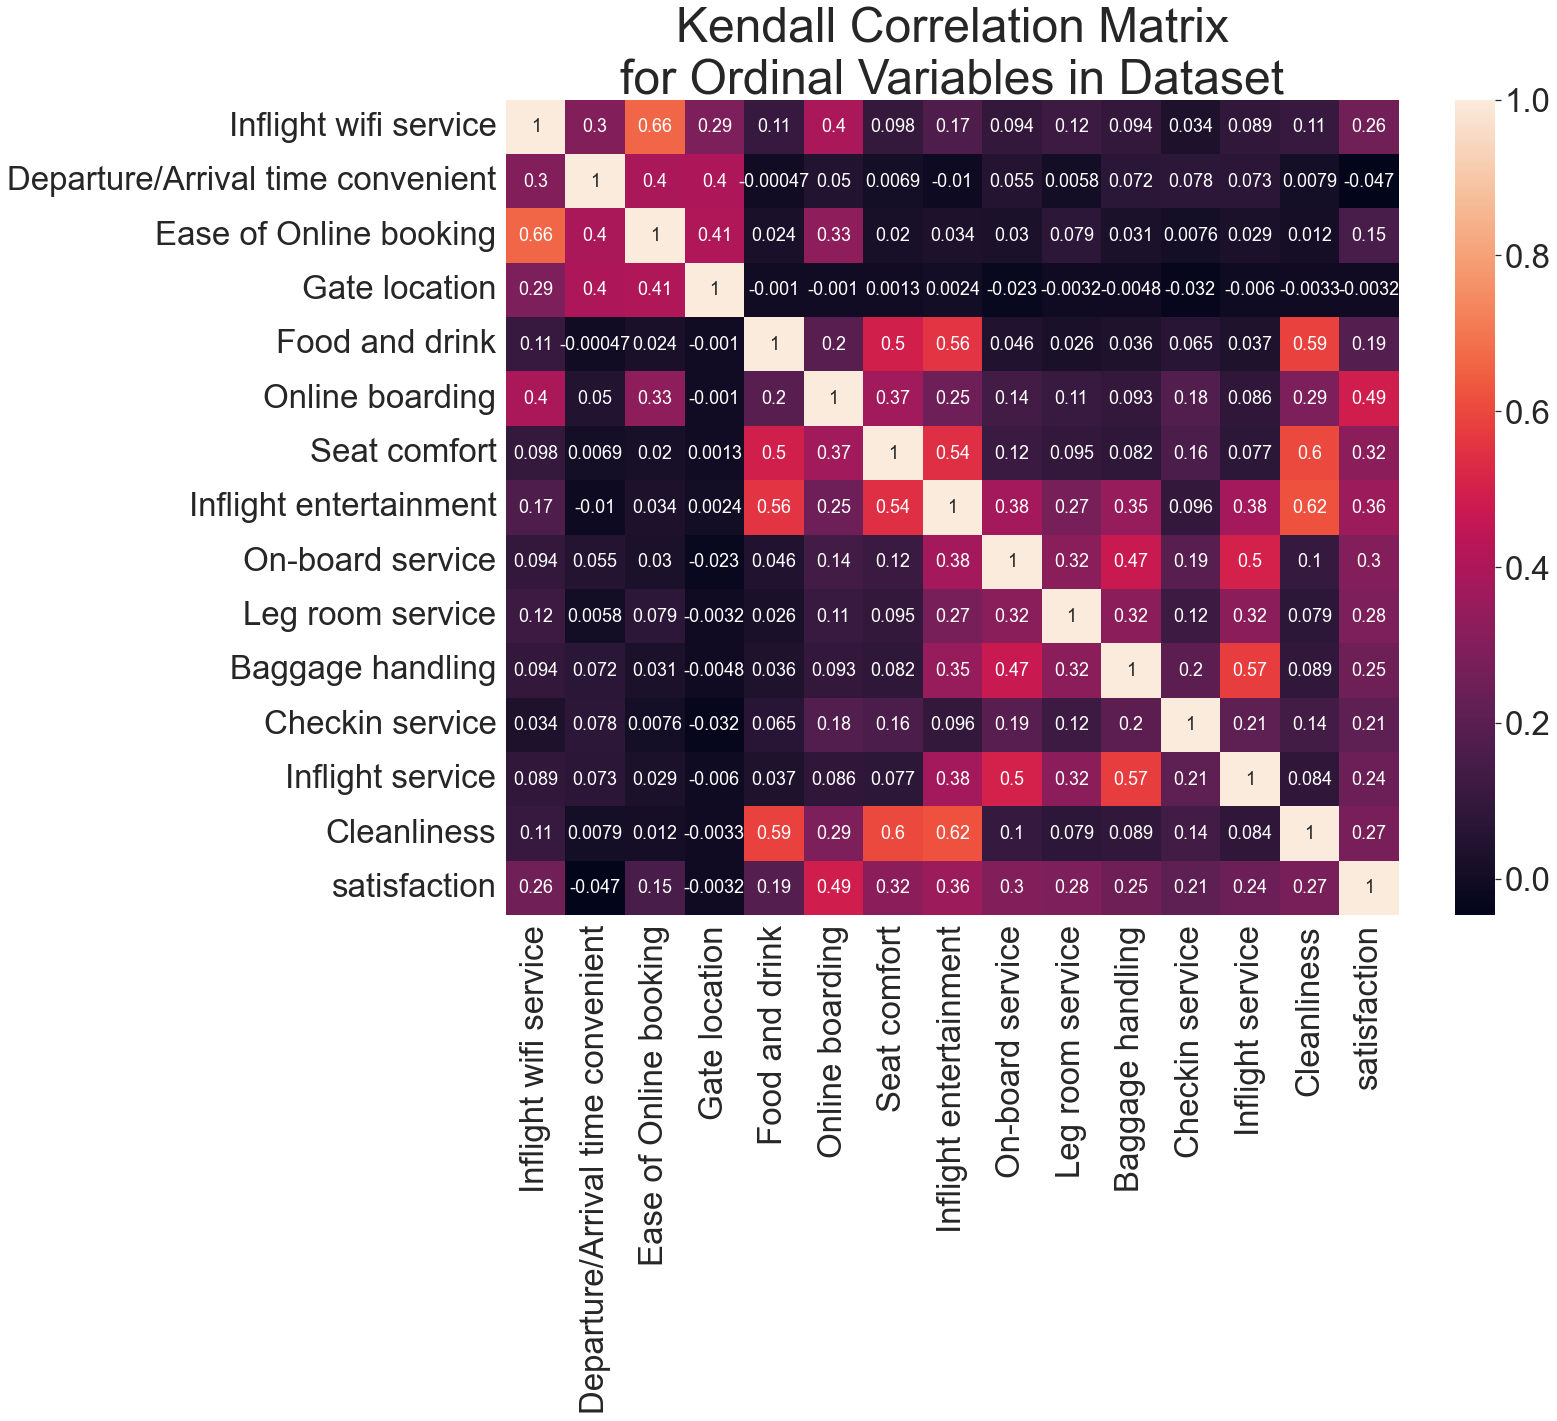

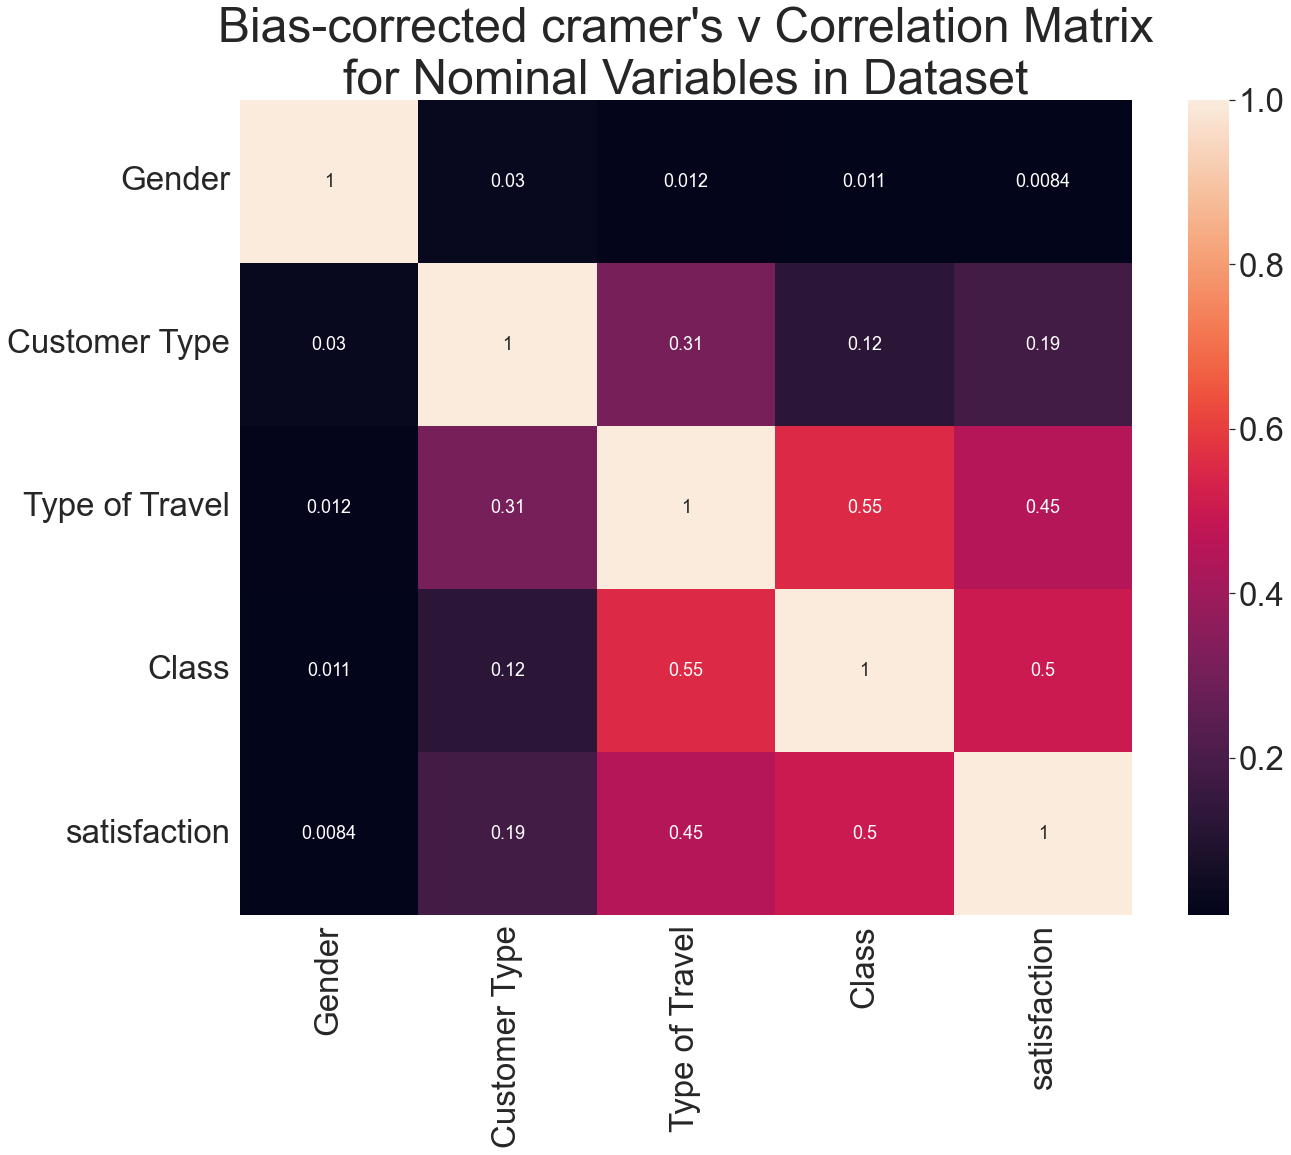

In [16]:
cc_numerical.illustrate()
cc_ordinal.illustrate()
cc_nominal.illustrate()

pass


#### Assumptions and Observations

It may be rather uncommon to have many highly-correlated features. In this dataset, this seems to be prevalent. There seems to be multiple groups among which, the variables are highly correlated which are also correlated to the output "satisfaction". These are Group 1, 2 and 3

- The correlation between ratings of "Cleanliness" and ratings of "Food and Drink", "Seat Comfort" and especially "Inflight entertainment" was unexpected. It may be note-worthy to further investigate this by possibly including other categorical features. (Group 1)

- The correlations among the ratings of "Baggage Handling", "Onboard Service" and "Inflight Service" is noteworthy. (Group 2)

- The correlation between "Class" and "Type of Travel" is significant, just like their correlation with the output "satisfaction". It may be beneficial to inspect this further. (Group 3)

Some features have a strong correlation with output, which causes the said feature -by itself- to have predictive capability of the output.

- The output "satisfaction" has a relatively high correlation with "Online Boarding", which was also not expected. (Group 4)

By using Tableau, one can visualize the underlying distributions:

> """Group 1:"""

The overwhelming majority of data is distributed in a way that, each of the values for these features (all of which are in likert scale from 0-5) are equal (or very close) to eachother for any arbitrary example. This implicitly explains the reason why this group of features were found to be highly correlated among each other from previous bivariate analysis. This also indicates that the **data acquisition process 
 may involve ambiguity for the survey questions regarding 
these features.**

![Distribution of Group 1](docs/group1.png)

> """Group 2:"""

The syndrome with Group 1 also happens to exist for this group.

![Distribution of Group 2](docs/group2.png)

> """Group 3:"""

Text(0.5, 1.0, "Proportion of \n'Satisfaction' across \nPassenger Ticket 'Class'")

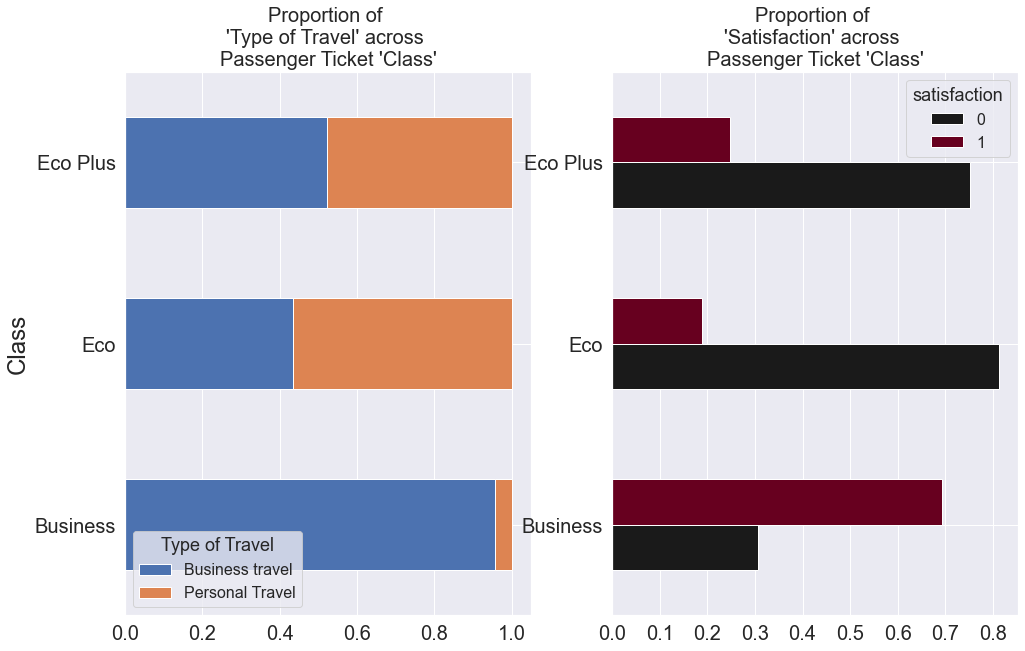

In [17]:
"""Group 3:"""

group3_view = df_train.groupby(["Type of Travel", "Class"])
group3 = group3_view.size().unstack(level=0)
group3_aug = group3.div(group3.sum(axis=1), axis=0)

# Plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,10))
# fig.suptitle("Distribution")

# Subplot 1
group3_aug.plot(stacked=True, kind="barh", ax=axes[0], fontsize=20)
axes[0].set_title(
    "Proportion of \n'Type of Travel' across \nPassenger Ticket 'Class'",
    fontsize=20,
)
axes[0].set_ylabel("Class", fontsize=24)
axes[0].legend(loc="lower left", fontsize=16,
               title="Type of Travel", title_fontsize=18)

# Subplot 2
cmap = plt.get_cmap("RdGy_r")
dummy = pd.crosstab(df_train["Class"], df_train["satisfaction"])
group3_satisfaction = dummy.div(dummy.sum(axis=1), axis=0)
del dummy
group3_satisfaction.plot(
    kind="barh", colormap=cmap, ax=axes[1],
    fontsize=20
)
axes[1].set_ylabel("", fontsize=24)
axes[1].legend(loc="upper right", fontsize=16,
               title="satisfaction", title_fontsize=18)
axes[1].set_title(
    "Proportion of \n'Satisfaction' across \nPassenger Ticket 'Class'",
    fontsize=20,
)


The overwhelming majority of Business class tickets are sold to business travelers. However, it is interesting to see that even "Eco" & "Eco plus" tickets have a lot of purchases by business travelers. Also it is clear that the majority of customers flying in Eco & Eco Plus class is not satisfied, whereas the majority of business class flyers are satisfied.

> """Group 4:"""

<Figure size 576x360 with 0 Axes>

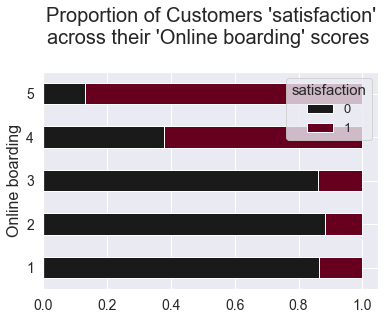

In [18]:
"""Group 4:"""
# group4 = pd.crosstab(
#     df_train["Online boarding"], 
#     df_train[ "satisfaction"]
# )

group4 = pd.crosstab(
    pd.cut(
        df_train["Online boarding"], 
        bins=[ 0.5, 1.5, 2.5, 3.5, 4.5, 5],
        labels=["1", "2", "3", "4", "5"]
    ),
    df_train[ "satisfaction"]
)

group4_aug = group4.div(group4.sum(axis=1), axis=0)
fig = plt.figure(figsize=(8,5))
ax = group4_aug.plot(stacked=True, kind="barh", fontsize=14, colormap=cmap)
ax.set_ylabel("Online boarding", fontsize=16)
ax.legend(loc="upper right", fontsize=13,
           title="satisfaction", title_fontsize=15)
ax.set_title("Proportion of Customers 'satisfaction'\n"
    "across their 'Online boarding' scores \n",
    fontsize=20,
)
pass
# group4_aug

It is interesting to observe that:
- the majority of customers who rank their 'Online boarding' service highly also state that they are satisfied
- the majority of customers who rank their 'Online boarding service poorly, also state that they are not satisfied.

#### Dimensionality Reduction
It may be beneficial to remove features that are very weakly correlated to output 'satisfaction', and features that are inter-correlated which seems to exist in this dataset.

In [19]:
removed_feature_names = list()
removed_feature_nums = list()

In [20]:
"""
Filter the correlations where a feature's correlation to the output 
is smaller than a threshold
"""
output_var = "satisfaction"
threshold = 0.1  # :TODO: to be tuned, may be specified per variabletype

redundant_numerical_features, redundant_numerical_nums  = \
    cc_numerical.filter(output_var, threshold=threshold)

redundant_ordinal_features, redundant_ordinal_nums  = \
    cc_ordinal.filter(output_var, threshold=threshold)

redundant_nominal_features, redundant_nominal_nums  = \
    cc_nominal.filter(output_var, threshold=threshold)

redundant_feature_names = redundant_numerical_features \
                        + redundant_ordinal_features \
                        + redundant_nominal_features

redundant_feature_nums = redundant_numerical_nums \
                       + redundant_ordinal_nums \
                       + redundant_numerical_nums


In [21]:
"""
Declare other redundant features within Groups by hand, 
which are shown to have multicolliniarity
"""

# Group 1
g1 = ["Seat comfort", "Food and drink"]

# Group 2
g2 = ["Baggage handling", "Inflight service"]

# Group 3
g3 = ["Type of Travel"]

#
"""
Remove redundant features from analysis
"""
omitted_feature_names: list = g1 + g2 + g3
omitted_feature_nums = [
    dataset_cols.to_list().index(i) for i in omitted_feature_names
]

In [22]:
"""
Remove redundant features from analysis
"""

# Declare which features will be removed
removed_feature_names = redundant_feature_names \
                        + omitted_feature_names

removed_feature_nums = redundant_feature_nums \
                       + omitted_feature_nums


# Filtering variables that are NOT to be removed
sieve_removed = (lambda x: x not in removed_feature_nums) 
numerical_vars = list(filter(sieve_removed, numerical_vars))
nominal_vars = list(filter(sieve_removed, nominal_vars))
ordinal_vars = list(filter(sieve_removed, ordinal_vars))


# Print removed variables
print("--- Features Removed from Analysis due to low correlation with output ---")
# Print Redundant Features
for name, num in list(zip(redundant_feature_names, redundant_feature_nums)):
    print(f"{num}: {name}")

print("--- Features Removed from Analysis due to high multicollinearity ---")
# Print Omitted Features
for name, num in list(zip(omitted_feature_names, omitted_feature_nums)):
    print(f"{num}: {name}")


--- Features Removed from Analysis due to low correlation with output ---
21: Departure Delay in Minutes
22: Arrival Delay in Minutes
8: Departure/Arrival time convenient
10: Gate location
21: Gender
--- Features Removed from Analysis due to high multicollinearity ---
13: Seat comfort
11: Food and drink
17: Baggage handling
19: Inflight service
4: Type of Travel


In [23]:
print("--- Remaining Features in Analysis ---")
remaining_feature_nums = numerical_vars + nominal_vars + ordinal_vars
remaining_feature_names = [
    variables_num2name[i] for i in remaining_feature_nums
]
# df_train.drop()

# print(numerical_vars)
# print(ordinal_vars)
# print(nominal_vars)
print(sorted(remaining_feature_nums),end="\n\n")

for feature_num in sorted(remaining_feature_nums):
    print(f"{feature_num}: {variables_num2name[feature_num]}" )

--- Remaining Features in Analysis ---
[1, 2, 3, 5, 6, 7, 9, 12, 14, 15, 16, 18, 20]

1: Gender
2: Customer Type
3: Age
5: Class
6: Flight Distance
7: Inflight wifi service
9: Ease of Online booking
12: Online boarding
14: Inflight entertainment
15: On-board service
16: Leg room service
18: Checkin service
20: Cleanliness


In [24]:
"""
Display the reduced view
"""
training_data.iloc[:,remaining_feature_nums].head(3)

,Age,Flight Distance,Gender,Customer Type,Class,Inflight wifi service,Ease of Online booking,Online boarding,Inflight entertainment,On-board service,Leg room service,Checkin service,Cleanliness
0,45,292,Male,Loyal Customer,Business,5,5,2,4,4,4,3,4
1,43,872,Female,Loyal Customer,Eco,4,3,5,4,4,4,3,3
2,28,261,Male,Loyal Customer,Business,2,3,2,2,4,4,1,2


#### Summary

Some features are eliminated because they have very low correlation to output and 
are redundant

Some geatures are eliminated because they have comparatively high correlation to each-other
and are redundant
  

### Data Cleaning and Encoding

Within workflow, Data Imputation and Cleaning is relevant
- In case data contains missing values
- It can be understood if there are missing values

Nominal variables are chosen to be encoded with One-hot encoding. 

In [25]:
"""
Data Cleaning
# Since my understanding of dealing with missing data is limited, 
# I am employing classical and well-developed methods.
"""
# :FIXME:

numerical_imputer = SimpleImputer(missing_values=np.nan, strategy='median')
categorical_imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
# categorical_imputer = KNNImputer(missing_values=np.nan, 
#                                  n_neighbors=10, 
#                                  weights="distance")

df_train.iloc[:, numerical_vars] = numerical_imputer.fit_transform(
    training_data.iloc[:, numerical_vars]
)

df_train.iloc[:, nominal_vars + ordinal_vars] = categorical_imputer.fit_transform(
    training_data.iloc[:, nominal_vars + ordinal_vars]
)

In [26]:
df_train.isnull().sum()

id                                     0
Gender                                 0
Customer Type                          0
Age                                    0
Type of Travel                         0
Class                                  0
Flight Distance                        0
Inflight wifi service                  0
Departure/Arrival time convenient      0
Ease of Online booking                 0
Gate location                          0
Food and drink                         0
Online boarding                        0
Seat comfort                           0
Inflight entertainment                 0
On-board service                       0
Leg room service                       0
Baggage handling                       0
Checkin service                        0
Inflight service                       0
Cleanliness                            0
Departure Delay in Minutes             0
Arrival Delay in Minutes             329
satisfaction                           0
dtype: int64

In [32]:
"""
Restructuring the datasets
"""
X_train = training_data.iloc[:,remaining_feature_nums].to_numpy()
X_dev = dev_data.iloc[:,remaining_feature_nums].to_numpy()
X_test = test_data.iloc[:,remaining_feature_nums].to_numpy()

Y_train = output_le.transform(Y_train.reshape((-1,)))
Y_dev = output_le.transform(Y_dev.reshape((-1,)))
Y_test = output_le.transform(Y_test.reshape((-1,)))

In [ ]:
pipeline = Pipeline(
    
)

In [ ]:
ohe = OneHotEncoder()
ct = ColumnTransformer(
    transformers=[('encoder', ohe, [1,2,4,5])],
    remainder="passthrough"  # Keep other feature columns after transformation
)
X = np.array(ct.fit_transform(X))

print(X, X.shape, sep="\n")

---

# REDUNDANT

In [ ]:
def calc_entropy(ls):
    from math import log2
    sum = 0
    for i in ls:
        sum += -(i*log2(i))
    return sum

print(
calc_entropy([0.47880147883826585, 0.44903158165799106, 0.07216693950374309]),
calc_entropy([0.691063, 0.308937]), # Type of Travel
calc_entropy([0.565407, 0.434593]) # Satisfaction
)


1.3011026287870149 0.891942594493103 0.9876206342677114


In [ ]:
"""
Dimensionality Reduction Through Correlated Features
"""

# Snippet from:
# https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python

k = correlation_matrix.shape[0] - 5
cols = correlation_matrix.nlargest(k, 'satisfaction')['satisfaction'].index
reduced_cm = np.corrcoef(df_train[cols].values.T)
sns.set(font_scale=3)
fig = plt.figure(figsize=(20, 15))
ax = sns.heatmap(reduced_cm, 
    cbar=True, annot=True, square=True, fmt='.3f', 
    annot_kws={'size': 14},
    yticklabels=cols.values, 
    xticklabels=cols.values
)
ax.set_title("Correlation Matrix of Prevalent Features", fontsize=48)
fig.add_axes(ax)

sns.set(font_scale=1)
plt.draw()
plt.show()


NameError: name 'correlation_matrix' is not defined

In [ ]:
# The outputs are either "Satisfied" or "neutral or dissatisfied"
le = LabelEncoder()  
# Since output labels are of binary nature, no need for LabelBinarizer

Y = le.fit_transform(Y)
print(Y)
